##Imports and data loading

In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
import glob
import os
import re
import string
import nltk
import contractions
from nltk import WordNetLemmatizer, word_tokenize
from nltk.corpus import stopwords
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!cp "./drive/MyDrive/test task/aclImdb_v1.tar.gz" ./dataset.tar.gz

In [ ]:
!tar -xf dataset.tar.gz

##Text preprocessing

In [ ]:
#preprocessing function for a BoW model
def preprocess(data_path, lemmatizer, stop_words):
  punct = string.punctuation
  data_neg_paths = glob.glob(os.path.join(data_path,'neg/*'))
  data_pos_paths = glob.glob(os.path.join(data_path,'pos/*'))

  paths = data_neg_paths + data_pos_paths

  data = []
  ratings = []

  for path in paths:
    rating = int(path.split('/')[-1].split('_')[-1][:-4])
    ratings.append(rating)

    with open(path,'r') as inp:
      text = inp.read()

    #remove html tags
    text = re.sub('<.*?>', '', text)
    #expand contractions (haven't -> have not)
    text = contractions.fix(text)
    #get rid of non-alphabetic characters
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)

    #tokenize text and turn it into lemmas
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in stop_words and t not in punct]
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]

    data.append(lemmas)

  return data, ratings

In [ ]:
# define lemmatizer and stop_words to be removed
lemmatizer = WordNetLemmatizer()

stop_words = list(set(stopwords.words('english')))
stop_words.remove('no')
stop_words.remove('not')

In [ ]:
dataTest, ratingsTest = preprocess("./aclImdb/test",lemmatizer,stop_words)

In [ ]:
dataTrain, ratingsTrain = preprocess("./aclImdb/train",lemmatizer,stop_words)

In [ ]:
ratingsTrain = np.array(ratingsTrain)
ratingsTest = np.array(ratingsTest)

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
vectorizer.fit([" ".join(s) for s in dataTrain])

CountVectorizer()

In [ ]:
dataTrainCounts = vectorizer.transform([" ".join(s) for s in dataTrain])
dataTestCounts = vectorizer.transform([" ".join(s) for s in dataTest])

In [ ]:
dataTrainCounts = dataTrainCounts.astype(np.float64)
dataTestCounts = dataTestCounts.astype(np.float64)

In [ ]:
dataTestCounts.shape

(25000, 66365)

In [ ]:
dataTrainCounts.shape

(25000, 66365)

##Model Training

In [ ]:
#Grid search to find the optimal combination of parameters
params = {
    'num_leaves': [31, 64, 127],
    'learning_rate': [0.1, 0.03, 0.003],
    'n_estimators': [100, 200, 500]
}

grid = GridSearchCV(lgb.LGBMRegressor(random_state=0, n_jobs=-1), params, scoring='r2', cv=5, verbose=10, n_jobs=-1)
grid.fit(dataTrainCounts, ratingsTrain/10)

lgbm_tuned = grid.best_estimator_

params = grid.best_params_

In [ ]:
lgbm_tuned

LGBMRegressor(learning_rate=0.03, n_estimators=500, num_leaves=127,
              random_state=0)

In [ ]:
params

{'learning_rate': 0.03, 'n_estimators': 500, 'num_leaves': 127}

In [ ]:
clf = lgbm_tuned

##Scoring the model

In [ ]:
train_r2 = clf.score(dataTrainCounts, ratingsTrain/10)

In [ ]:
test_r2 = clf.score(dataTestCounts, ratingsTest/10)

In [ ]:
test_preds = clf.predict(dataTestCounts)
test_preds[test_preds<0.1] = 0.1
test_preds[test_preds>1] = 1

In [ ]:
test_preds = np.load(open("./test_preds_bow.npy",'rb'))

In [ ]:
train_preds = clf.predict(dataTrainCounts)
train_preds[train_preds<0.1] = 0.1
train_preds[train_preds>1] = 1

In [ ]:
test_rmse = mean_squared_error(ratingsTest/10,test_preds, squared=False)

In [ ]:
train_rmse = mean_squared_error(ratingsTrain/10,train_preds, squared=False)

In [ ]:
print(f"R2: test={round(test_r2,3)}, train={round(train_r2,3)}")
print(f"RMSE: test={round(test_rmse,3)}, train={round(train_rmse,3)}")

R2: test=0.617, train=0.884
RMSE: test=0.216, train=0.118


Regressor: ROC AUC=0.938


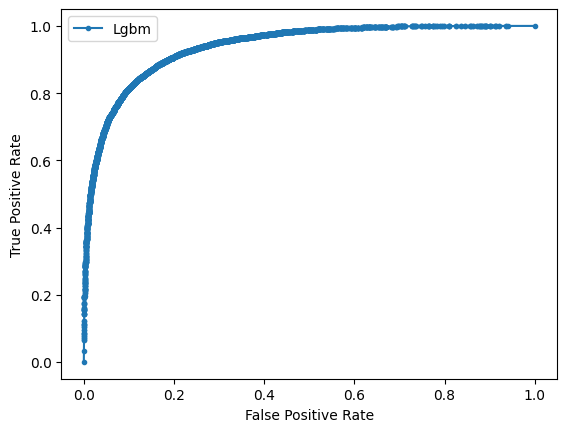

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


test_labels = [1 if l > 4 else 0 for l in ratingsTest]

auc = roc_auc_score(test_labels, test_preds)

# summarize scores
print('Regressor: ROC AUC=%.3f' % (auc))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='Lgbm')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [ ]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_thresh = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_thresh, gmeans[ix]))

Best Threshold=0.556235, G-Mean=0.860


In [ ]:
test_preds_labels = np.array([1 if s >best_thresh else 0 for s in test_preds])

In [ ]:
print(classification_report(test_labels, test_preds_labels))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [ ]:
test_preds_scores = np.array([s*10 for s in test_preds])

In [ ]:
preds_by_rating = {}

for r,p in zip(ratingsTest,test_preds_scores):
  if r not in preds_by_rating:
    preds_by_rating[r] = []

  preds_by_rating[r].append(p)

rating: 1, preds mean: 2.8, std: 1.57
rating: 2, preds mean: 3.33, std: 1.663
rating: 3, preds mean: 3.877, std: 1.645
rating: 4, preds mean: 4.436, std: 1.689
rating: 7, preds mean: 6.61, std: 1.63
rating: 8, preds mean: 7.231, std: 1.592
rating: 9, preds mean: 7.613, std: 1.56
rating: 10, preds mean: 7.887, std: 1.573


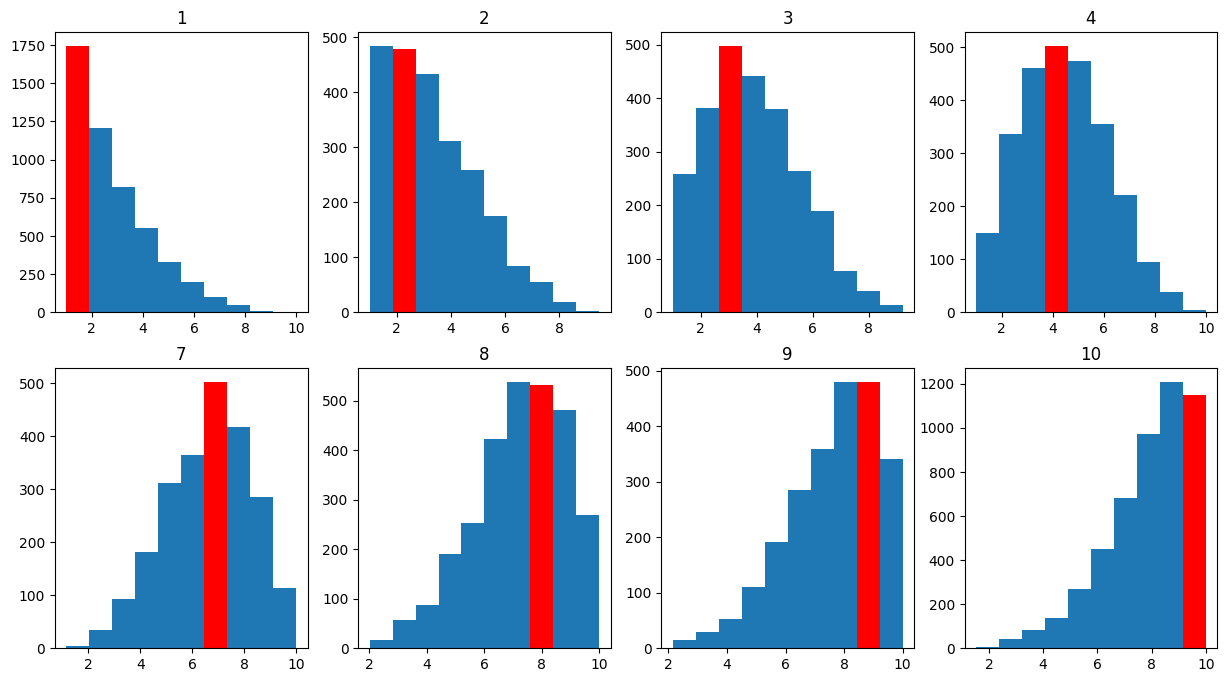

In [ ]:
f, axs = plt.subplots(2, 4, figsize=(15, 8))

for id,rating in enumerate(sorted(preds_by_rating.keys())):
  preds = np.array(preds_by_rating[rating])
  print(f"rating: {rating}, preds mean: {round(preds.mean(),3)}, std: {round(preds.std(),3)}")
  plt.subplot(2,4,id+1)
  n, bins, patches = plt.hist(preds)
  patches[rating-1].set_fc('r')
  plt.title(rating)
plt.show()

##Save model and predictions

In [ ]:
import joblib

In [ ]:
joblib.dump(clf, 'BoW_lgbm.pkl')

['BoW_lgbm.pkl']

In [ ]:
joblib.dump(vectorizer, 'BoW_lgbm_vectorizer.pkl')

['BoW_lgbm_vectorizer.pkl']

In [ ]:
with open('test_preds_bow.npy','wb') as out:
  np.save(out,test_preds)